In [16]:
# import modules from other folders
# source: https://stackoverflow.com/questions/49264194/import-py-file-in-another-directory-in-jupyter-notebook
# author: adhg (accessed 15 June 2025)
import os
import sys

# Build an absolute path from this notebook's parent directory
module_path = os.path.abspath(os.path.join('..', 'src/python'))
# Add to sys.path if not already present
if module_path not in sys.path:
    sys.path.append(module_path)

from train_logistic_model import *
from lexicon import create_lexicon
import config as cfg

In [2]:
# computationally expensive
# prefer loading dataset when possibile

try:
    df_train = pd.read_csv(cfg.DATAFRAME_SAVE_PATH / "df_train.csv")
    df_val = pd.read_csv(cfg.DATAFRAME_SAVE_PATH / "df_val.csv")
    df_test = pd.read_csv(cfg.DATAFRAME_SAVE_PATH / "df_test.csv")
except FileNotFoundError:
    df_train, df_val, df_test = create_data_splits_with_kb_features(merge_train_test())

#### Train baseline model

In [ ]:
# generate lexicon on train data
create_lexicon(df_train)

In [3]:
X_train, y_train = split_feature_target(df_train, "label")
X_val, y_val = split_feature_target(df_val, "label")

In [4]:
pipeline = create_pipeline()
pipeline.fit(X_train, y_train)

,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('tfidf', ...), ('kbnum', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


#### Valuate baseline model

In [5]:
y_val_pred = pipeline.predict(X_val)
y_val_proba = pipeline.predict_proba(X_val)[:,1]

Acc val: 0.8929
AUC val: 0.9597508000000001
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5000
           1       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



Acc val: 0.8929
AUC val: 0.9597508000000001
LogLoss: 0.2811467789915403
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5000
           1       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



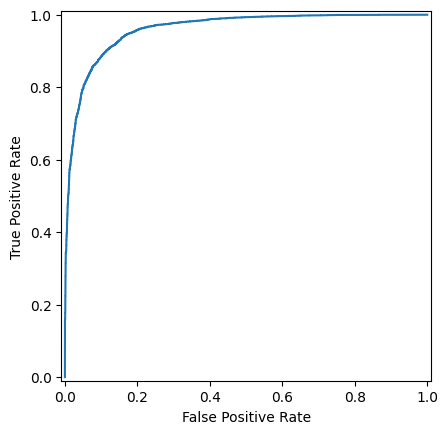

In [14]:
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, classification_report
from sklearn.metrics import roc_curve, RocCurveDisplay

print("Acc val:", accuracy_score(y_val, y_val_pred))
print("AUC val:", roc_auc_score(y_val, y_val_proba))
print("LogLoss:", log_loss(y_val, y_val_proba))
print(classification_report(y_val, y_val_pred))

# ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [18]:
import joblib
joblib.dump(pipeline, "../models/baseline.pkl")

['../models/baseline.pkl']

#### Cross-Validation

In [19]:
param_grid = {
    # TF-IDF
    "pre__tfidf__ngram_range": [(1,1),(1,2)],
    "pre__tfidf__min_df": [5],
    "pre__tfidf__max_df": [0.9],
    # Classificatore
    "clf__C": [0.1, 1, 10]
}

from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,               
    scoring="roc_auc",   
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV AUC:", grid.best_score_)

best = grid.best_estimator_

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params: {'clf__C': 10, 'pre__tfidf__max_df': 0.9, 'pre__tfidf__min_df': 5, 'pre__tfidf__ngram_range': (1, 2)}
Best CV AUC: 0.9561259066666667


In [21]:
y_val_pred = best.predict(X_val)
y_val_proba = best.predict_proba(X_val)[:,1]

Acc val: 0.8911
AUC val: 0.9586534
LogLoss: 0.26167141256720633
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5000
           1       0.89      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



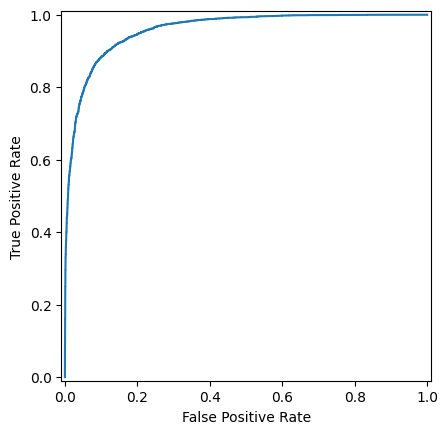

In [22]:
print("Acc val:", accuracy_score(y_val, y_val_pred))
print("AUC val:", roc_auc_score(y_val, y_val_proba))
print("LogLoss:", log_loss(y_val, y_val_proba))
print(classification_report(y_val, y_val_pred))

# ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [20]:
joblib.dump(best, "../models/best.pkl")

['../models/best.pkl']

#### Test Set

In [23]:
# train the model on both train and validation
df_train_val = pd.concat([df_train, df_val], ignore_index=True)

In [24]:
create_lexicon(df_train_val)

In [25]:
best_params = grid.best_params_
X_train_val, y_train_val = split_feature_target(df_train_val, "label")

final_pipeline = create_pipeline().set_params(**best_params)
final_pipeline.fit(X_train_val, y_train_val)

,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('tfidf', ...), ('kbnum', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [26]:
# valuate on test set
X_test, y_test = split_feature_target(df_test, "label")
y_pred = final_pipeline.predict(X_test)
y_proba = final_pipeline.predict_proba(X_test)[:, 1]

Acc val: 0.8995
AUC val: 0.9637908399999999
LogLoss: 0.245416453215184
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      5000
           1       0.90      0.90      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



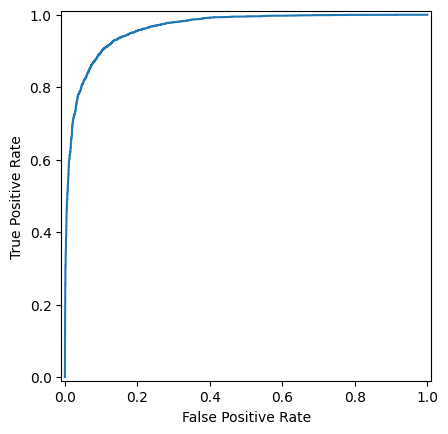

In [27]:
print("Acc val:", accuracy_score(y_test, y_pred))
print("AUC val:", roc_auc_score(y_test, y_proba))
print("LogLoss:", log_loss(y_test, y_proba))
print(classification_report(y_test, y_pred))

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [28]:
joblib.dump(final_pipeline, "../models/final.pkl")

['../models/final.pkl']